## Import Data ##

In [47]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [98]:
files = os.listdir()
data = [f for f in files if f.endswith(".csv")]

if data:
    df = pd.read_csv(data[0])
else:
    print("No data files found in the directory.")

df

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score,Premium_Adjustment_Credit,Region,Premium_Adjustment_Region
0,47,0,Married,86,1-5 years,50,0,Low,0,Full Coverage,...,10,0,5,1,2,99,704,-50,Suburban,50
1,37,0,Married,86,1-5 years,50,0,Low,0,Full Coverage,...,22,0,5,1,2,99,726,-50,Urban,100
2,49,0,Married,86,1-5 years,50,1,Low,50,Full Coverage,...,28,0,4,4,1,99,772,-50,Urban,100
3,62,1,Married,86,>5 years,0,1,Low,50,Full Coverage,...,4,1,6,2,2,2,809,-50,Urban,100
4,36,0,Single,0,>5 years,0,2,Low,100,Full Coverage,...,14,1,8,4,2,10,662,50,Suburban,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,59,1,Single,0,1-5 years,50,0,Low,0,Full Coverage,...,6,1,4,3,2,9,783,-50,Urban,100
9996,18,0,Married,86,1-5 years,50,0,Medium,0,Full Coverage,...,3,1,6,1,3,6,667,50,Urban,100
9997,29,0,Married,86,<1 year,100,0,Low,0,Full Coverage,...,29,1,3,4,3,3,637,50,Urban,100
9998,47,0,Single,0,<1 year,100,0,Medium,0,Liability-Only,...,8,1,2,4,1,13,676,50,Suburban,50


In [100]:
from sklearn.preprocessing import LabelEncoder

#Words to numbers
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = le.fit_transform(df[column])

In [102]:
#Standardize data, helpful for linear regression and Neural Networks

copy_df = df.copy()

for column in copy_df.columns:
    copy_df[column] = copy_df[column]/copy_df[column].abs().max()
copy_df

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score,Premium_Adjustment_Credit,Region,Premium_Adjustment_Region
0,0.522222,0.0,0.333333,1.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.333333,0.0,0.3125,0.111111,0.666667,1.000000,0.828235,-1.0,0.5,0.5
1,0.411111,0.0,0.333333,1.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.733333,0.0,0.3125,0.111111,0.666667,1.000000,0.854118,-1.0,1.0,1.0
2,0.544444,0.0,0.333333,1.0,0.0,0.5,0.2,0.5,0.0625,0.0,...,0.933333,0.0,0.2500,0.444444,0.333333,1.000000,0.908235,-1.0,1.0,1.0
3,0.688889,1.0,0.333333,1.0,1.0,0.0,0.2,0.5,0.0625,0.0,...,0.133333,1.0,0.3750,0.222222,0.666667,0.020202,0.951765,-1.0,1.0,1.0
4,0.400000,0.0,0.666667,0.0,1.0,0.0,0.4,0.5,0.1250,0.0,...,0.466667,1.0,0.5000,0.444444,0.666667,0.101010,0.778824,1.0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.655556,1.0,0.666667,0.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.200000,1.0,0.2500,0.333333,0.666667,0.090909,0.921176,-1.0,1.0,1.0
9996,0.200000,0.0,0.333333,1.0,0.0,0.5,0.0,1.0,0.0000,0.0,...,0.100000,1.0,0.3750,0.111111,1.000000,0.060606,0.784706,1.0,1.0,1.0
9997,0.322222,0.0,0.333333,1.0,0.5,1.0,0.0,0.5,0.0000,0.0,...,0.966667,1.0,0.1875,0.444444,1.000000,0.030303,0.749412,1.0,1.0,1.0
9998,0.522222,0.0,0.666667,0.0,0.5,1.0,0.0,1.0,0.0000,1.0,...,0.266667,1.0,0.1250,0.444444,0.333333,0.131313,0.795294,1.0,0.5,0.5


In [104]:
def drop():
    global X
    global y
    
    X = copy_df.drop(columns=["Premium_Adjustment_Region"])
    y = copy_df["Premium_Adjustment_Region"]

drop()
copy_df

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score,Premium_Adjustment_Credit,Region,Premium_Adjustment_Region
0,0.522222,0.0,0.333333,1.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.333333,0.0,0.3125,0.111111,0.666667,1.000000,0.828235,-1.0,0.5,0.5
1,0.411111,0.0,0.333333,1.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.733333,0.0,0.3125,0.111111,0.666667,1.000000,0.854118,-1.0,1.0,1.0
2,0.544444,0.0,0.333333,1.0,0.0,0.5,0.2,0.5,0.0625,0.0,...,0.933333,0.0,0.2500,0.444444,0.333333,1.000000,0.908235,-1.0,1.0,1.0
3,0.688889,1.0,0.333333,1.0,1.0,0.0,0.2,0.5,0.0625,0.0,...,0.133333,1.0,0.3750,0.222222,0.666667,0.020202,0.951765,-1.0,1.0,1.0
4,0.400000,0.0,0.666667,0.0,1.0,0.0,0.4,0.5,0.1250,0.0,...,0.466667,1.0,0.5000,0.444444,0.666667,0.101010,0.778824,1.0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.655556,1.0,0.666667,0.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.200000,1.0,0.2500,0.333333,0.666667,0.090909,0.921176,-1.0,1.0,1.0
9996,0.200000,0.0,0.333333,1.0,0.0,0.5,0.0,1.0,0.0000,0.0,...,0.100000,1.0,0.3750,0.111111,1.000000,0.060606,0.784706,1.0,1.0,1.0
9997,0.322222,0.0,0.333333,1.0,0.5,1.0,0.0,0.5,0.0000,0.0,...,0.966667,1.0,0.1875,0.444444,1.000000,0.030303,0.749412,1.0,1.0,1.0
9998,0.522222,0.0,0.666667,0.0,0.5,1.0,0.0,1.0,0.0000,1.0,...,0.266667,1.0,0.1250,0.444444,0.333333,0.131313,0.795294,1.0,0.5,0.5


## Data Clean Up ##

In [106]:
stats.zscore(copy_df) #Find outliers

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score,Premium_Adjustment_Credit,Region,Premium_Adjustment_Region
0,0.498824,-0.435299,-0.534823,1.020408,-0.868567,0.069136,-0.694321,-0.201040,-0.558059,-0.815306,...,-0.631285,-1.167215,-0.010232,-0.704265,0.003793,1.164604,-0.206111,-0.794222,-0.365148,-0.365148
1,-0.212938,-0.435299,-0.534823,1.020408,-0.868567,0.069136,-0.694321,-0.201040,-0.558059,-0.815306,...,0.751595,-1.167215,-0.010232,-0.704265,0.003793,1.164604,0.236127,-0.794222,0.909365,0.909365
2,0.641176,-0.435299,-0.534823,1.020408,-0.868567,0.069136,0.702141,-0.201040,0.200586,-0.815306,...,1.443036,-1.167215,-0.457036,1.415101,-1.219647,1.164604,1.160806,-0.794222,0.909365,0.909365
3,1.566465,2.297273,-0.534823,1.020408,1.494237,-1.386353,0.702141,-0.201040,0.200586,-0.815306,...,-1.322725,0.856740,0.436572,0.002190,0.003793,-0.969789,1.904569,-0.794222,0.909365,0.909365
4,-0.284114,-0.435299,0.743740,-0.980000,1.494237,-1.386353,2.098604,-0.201040,0.959231,-0.815306,...,-0.170325,0.856740,1.330180,1.415101,0.003793,-0.793757,-1.050383,1.259093,-0.365148,-0.365148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.352937,2.297273,0.743740,-0.980000,-0.868567,0.069136,-0.694321,-0.201040,-0.558059,-0.815306,...,-1.092245,0.856740,-0.457036,0.708645,0.003793,-0.815761,1.381925,-0.794222,0.909365,0.909365
9996,-1.565284,-0.435299,-0.534823,1.020408,-0.868567,0.069136,-0.694321,1.662164,-0.558059,-0.815306,...,-1.437965,0.856740,0.436572,-0.704265,1.227232,-0.881773,-0.949874,1.259093,0.909365,0.909365
9997,-0.782347,-0.435299,-0.534823,1.020408,0.312835,1.524625,-0.694321,-0.201040,-0.558059,-0.815306,...,1.558276,0.856740,-0.903839,1.415101,1.227232,-0.947785,-1.552926,1.259093,0.909365,0.909365
9998,0.498824,-0.435299,0.743740,-0.980000,0.312835,1.524625,-0.694321,1.662164,-0.558059,1.226533,...,-0.861765,0.856740,-1.350643,1.415101,-1.219647,-0.727744,-0.768959,1.259093,-0.365148,-0.365148


In [108]:
#Drop outliers
z = np.abs(stats.zscore(copy_df))
threshold_z = 3
outliers = np.where(z > threshold_z)[0]
copy_df = copy_df.drop(outliers)
copy_df

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score,Premium_Adjustment_Credit,Region,Premium_Adjustment_Region
0,0.522222,0.0,0.333333,1.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.333333,0.0,0.3125,0.111111,0.666667,1.000000,0.828235,-1.0,0.5,0.5
1,0.411111,0.0,0.333333,1.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.733333,0.0,0.3125,0.111111,0.666667,1.000000,0.854118,-1.0,1.0,1.0
2,0.544444,0.0,0.333333,1.0,0.0,0.5,0.2,0.5,0.0625,0.0,...,0.933333,0.0,0.2500,0.444444,0.333333,1.000000,0.908235,-1.0,1.0,1.0
3,0.688889,1.0,0.333333,1.0,1.0,0.0,0.2,0.5,0.0625,0.0,...,0.133333,1.0,0.3750,0.222222,0.666667,0.020202,0.951765,-1.0,1.0,1.0
4,0.400000,0.0,0.666667,0.0,1.0,0.0,0.4,0.5,0.1250,0.0,...,0.466667,1.0,0.5000,0.444444,0.666667,0.101010,0.778824,1.0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.655556,1.0,0.666667,0.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.200000,1.0,0.2500,0.333333,0.666667,0.090909,0.921176,-1.0,1.0,1.0
9996,0.200000,0.0,0.333333,1.0,0.0,0.5,0.0,1.0,0.0000,0.0,...,0.100000,1.0,0.3750,0.111111,1.000000,0.060606,0.784706,1.0,1.0,1.0
9997,0.322222,0.0,0.333333,1.0,0.5,1.0,0.0,0.5,0.0000,0.0,...,0.966667,1.0,0.1875,0.444444,1.000000,0.030303,0.749412,1.0,1.0,1.0
9998,0.522222,0.0,0.666667,0.0,0.5,1.0,0.0,1.0,0.0000,1.0,...,0.266667,1.0,0.1250,0.444444,0.333333,0.131313,0.795294,1.0,0.5,0.5


In [110]:
copy_df.isna().sum()

Age                                   0
Is_Senior                             0
Marital_Status                        0
Married_Premium_Discount              0
Prior_Insurance                       0
Prior_Insurance_Premium_Adjustment    0
Claims_Frequency                      0
Claims_Severity                       0
Claims_Adjustment                     0
Policy_Type                           0
Policy_Adjustment                     0
Premium_Amount                        0
Safe_Driver_Discount                  0
Multi_Policy_Discount                 0
Bundling_Discount                     0
Total_Discounts                       0
Source_of_Lead                        0
Time_Since_First_Contact              0
Conversion_Status                     0
Website_Visits                        0
Inquiries                             0
Quotes_Requested                      0
Time_to_Conversion                    0
Credit_Score                          0
Premium_Adjustment_Credit             0


In [ ]:
copy_df = copy_df.dropna(inplace = True) #drop rows with missing values

In [112]:
copy_df.duplicated().sum()

0

In [ ]:
copy_df = copy_df.drop_duplicates(inplace = True) #drop duplicate rows

In [114]:
drop()
copy_df

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score,Premium_Adjustment_Credit,Region,Premium_Adjustment_Region
0,0.522222,0.0,0.333333,1.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.333333,0.0,0.3125,0.111111,0.666667,1.000000,0.828235,-1.0,0.5,0.5
1,0.411111,0.0,0.333333,1.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.733333,0.0,0.3125,0.111111,0.666667,1.000000,0.854118,-1.0,1.0,1.0
2,0.544444,0.0,0.333333,1.0,0.0,0.5,0.2,0.5,0.0625,0.0,...,0.933333,0.0,0.2500,0.444444,0.333333,1.000000,0.908235,-1.0,1.0,1.0
3,0.688889,1.0,0.333333,1.0,1.0,0.0,0.2,0.5,0.0625,0.0,...,0.133333,1.0,0.3750,0.222222,0.666667,0.020202,0.951765,-1.0,1.0,1.0
4,0.400000,0.0,0.666667,0.0,1.0,0.0,0.4,0.5,0.1250,0.0,...,0.466667,1.0,0.5000,0.444444,0.666667,0.101010,0.778824,1.0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.655556,1.0,0.666667,0.0,0.0,0.5,0.0,0.5,0.0000,0.0,...,0.200000,1.0,0.2500,0.333333,0.666667,0.090909,0.921176,-1.0,1.0,1.0
9996,0.200000,0.0,0.333333,1.0,0.0,0.5,0.0,1.0,0.0000,0.0,...,0.100000,1.0,0.3750,0.111111,1.000000,0.060606,0.784706,1.0,1.0,1.0
9997,0.322222,0.0,0.333333,1.0,0.5,1.0,0.0,0.5,0.0000,0.0,...,0.966667,1.0,0.1875,0.444444,1.000000,0.030303,0.749412,1.0,1.0,1.0
9998,0.522222,0.0,0.666667,0.0,0.5,1.0,0.0,1.0,0.0000,1.0,...,0.266667,1.0,0.1250,0.444444,0.333333,0.131313,0.795294,1.0,0.5,0.5


## Statistical Modeling ##

In [116]:
copy_df.describe()

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score,Premium_Adjustment_Credit,Region,Premium_Adjustment_Region
count,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,...,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,8679.000000,8679.00000,8679.00000
mean,0.442218,0.155778,0.474133,0.487038,0.366344,0.476265,0.088374,0.557841,0.038520,0.396129,...,0.515981,0.574375,0.311139,0.218894,0.666283,0.467456,0.840525,-0.223874,0.64368,0.64368
std,0.154294,0.362666,0.260585,0.499861,0.423097,0.342942,0.124234,0.265988,0.061864,0.489120,...,0.288872,0.494466,0.135301,0.152411,0.272181,0.459468,0.058401,0.974674,0.39315,0.39315
min,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.033333,0.000000,0.000000,0.000000,0.333333,0.010101,0.668235,-1.000000,0.00000,0.00000
25%,0.322222,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.266667,0.000000,0.187500,0.111111,0.333333,0.060606,0.801176,-1.000000,0.50000,0.50000
50%,0.433333,0.000000,0.333333,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,...,0.500000,1.000000,0.312500,0.222222,0.666667,0.121212,0.841176,-1.000000,0.50000,0.50000
75%,0.544444,0.000000,0.666667,1.000000,1.000000,0.500000,0.200000,0.500000,0.062500,1.000000,...,0.766667,1.000000,0.375000,0.333333,1.000000,1.000000,0.880000,1.000000,1.00000,1.00000
max,0.911111,1.000000,1.000000,1.000000,1.000000,1.000000,0.400000,1.000000,0.250000,1.000000,...,1.000000,1.000000,0.687500,0.666667,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


In [122]:
#If columns need to be dropped
copy_df.drop(columns=["Bundling_Discount"], inplace=True, axis=1)

In [128]:
drop()

In [124]:
copy_df.corr()

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Time_Since_First_Contact,Conversion_Status,Website_Visits,Inquiries,Quotes_Requested,Time_to_Conversion,Credit_Score,Premium_Adjustment_Credit,Region,Premium_Adjustment_Region
Age,1.000000,0.688702,-0.009027,-0.016303,0.105108,-0.114533,-0.007061,0.002904,-0.002693,-0.007671,...,0.003395,0.014715,-0.024084,0.000792,0.018354,-0.015243,-0.001865,-0.002761,0.006941,0.006941
Is_Senior,0.688702,1.000000,-0.005318,-0.000302,0.042208,-0.047169,-0.010440,0.002747,-0.006824,-0.006864,...,-0.000667,0.016351,-0.014466,-0.004980,0.013447,-0.016514,-0.014071,0.003481,-0.006672,-0.006672
Marital_Status,-0.009027,-0.005318,1.000000,-0.526521,-0.003490,0.004304,0.016635,0.001361,0.008725,-0.009405,...,-0.011747,0.007554,-0.011723,0.002775,0.015204,-0.006963,0.024634,-0.008360,0.009099,0.009099
Married_Premium_Discount,-0.016303,-0.000302,-0.526521,1.000000,0.006246,0.001902,0.001563,0.004773,0.013936,0.009221,...,0.010386,-0.016263,0.019387,0.003131,0.000246,0.015702,-0.017333,0.006933,-0.014270,-0.014270
Prior_Insurance,0.105108,0.042208,-0.003490,0.006246,1.000000,-0.469984,0.009239,-0.003230,0.009610,-0.003336,...,-0.004317,0.017502,-0.001039,-0.009084,-0.000446,-0.016767,-0.001195,0.008189,-0.007676,-0.007676
Prior_Insurance_Premium_Adjustment,-0.114533,-0.047169,0.004304,0.001902,-0.469984,1.000000,-0.017567,0.009367,-0.012574,-0.012295,...,0.014104,-0.008616,-0.000153,0.001428,-0.000303,0.006669,0.006731,-0.012796,-0.000771,-0.000771
Claims_Frequency,-0.007061,-0.010440,0.016635,0.001563,0.009239,-0.017567,1.000000,0.034301,0.833153,-0.008781,...,0.004482,-0.027286,-0.000727,0.003907,-0.002177,0.025882,-0.014654,0.007909,-0.002837,-0.002837
Claims_Severity,0.002904,0.002747,0.001361,0.004773,-0.003230,0.009367,0.034301,1.000000,-0.004548,-0.027331,...,0.006140,0.008905,0.001487,-0.001725,-0.006590,-0.009302,-0.009653,0.009505,-0.009507,-0.009507
Claims_Adjustment,-0.002693,-0.006824,0.008725,0.013936,0.009610,-0.012574,0.833153,-0.004548,1.000000,-0.000688,...,-0.008429,-0.023387,0.002769,0.010460,0.002875,0.022328,-0.005818,-0.002568,-0.000606,-0.000606
Policy_Type,-0.007671,-0.006864,-0.009405,0.009221,-0.003336,-0.012295,-0.008781,-0.027331,-0.000688,1.000000,...,-0.007294,0.065418,-0.011441,0.014770,-0.021939,-0.062179,-0.000575,-0.014097,0.001215,0.001215


In [126]:
kstest(X, "norm").pvalue #p-value for each row

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

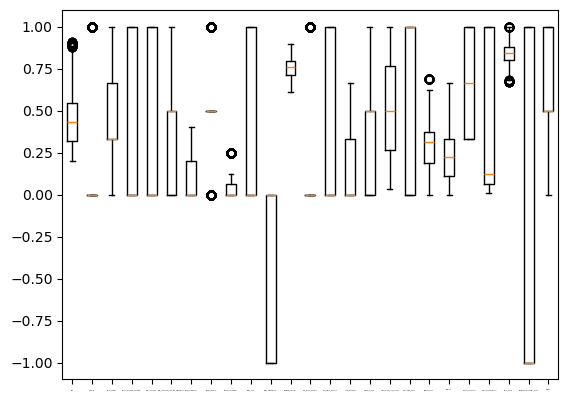

In [156]:
#When dealing with very large data-sets/working with others using graphs to see things would be beneficial to everyone's sanity
fig, ax = plt.subplots()
ax.boxplot(X)
ax.set_xticklabels(X.columns, size=1)
plt.show()

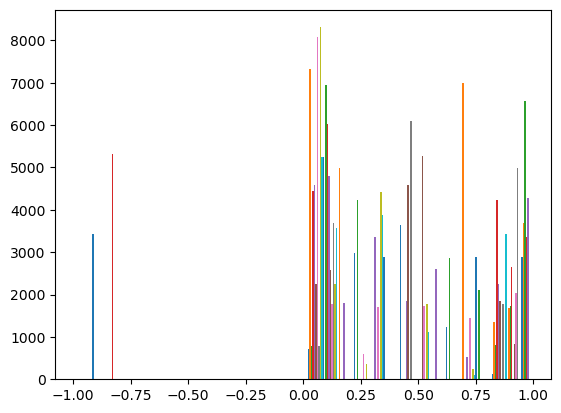

In [150]:
plt.hist(X)
plt.show()

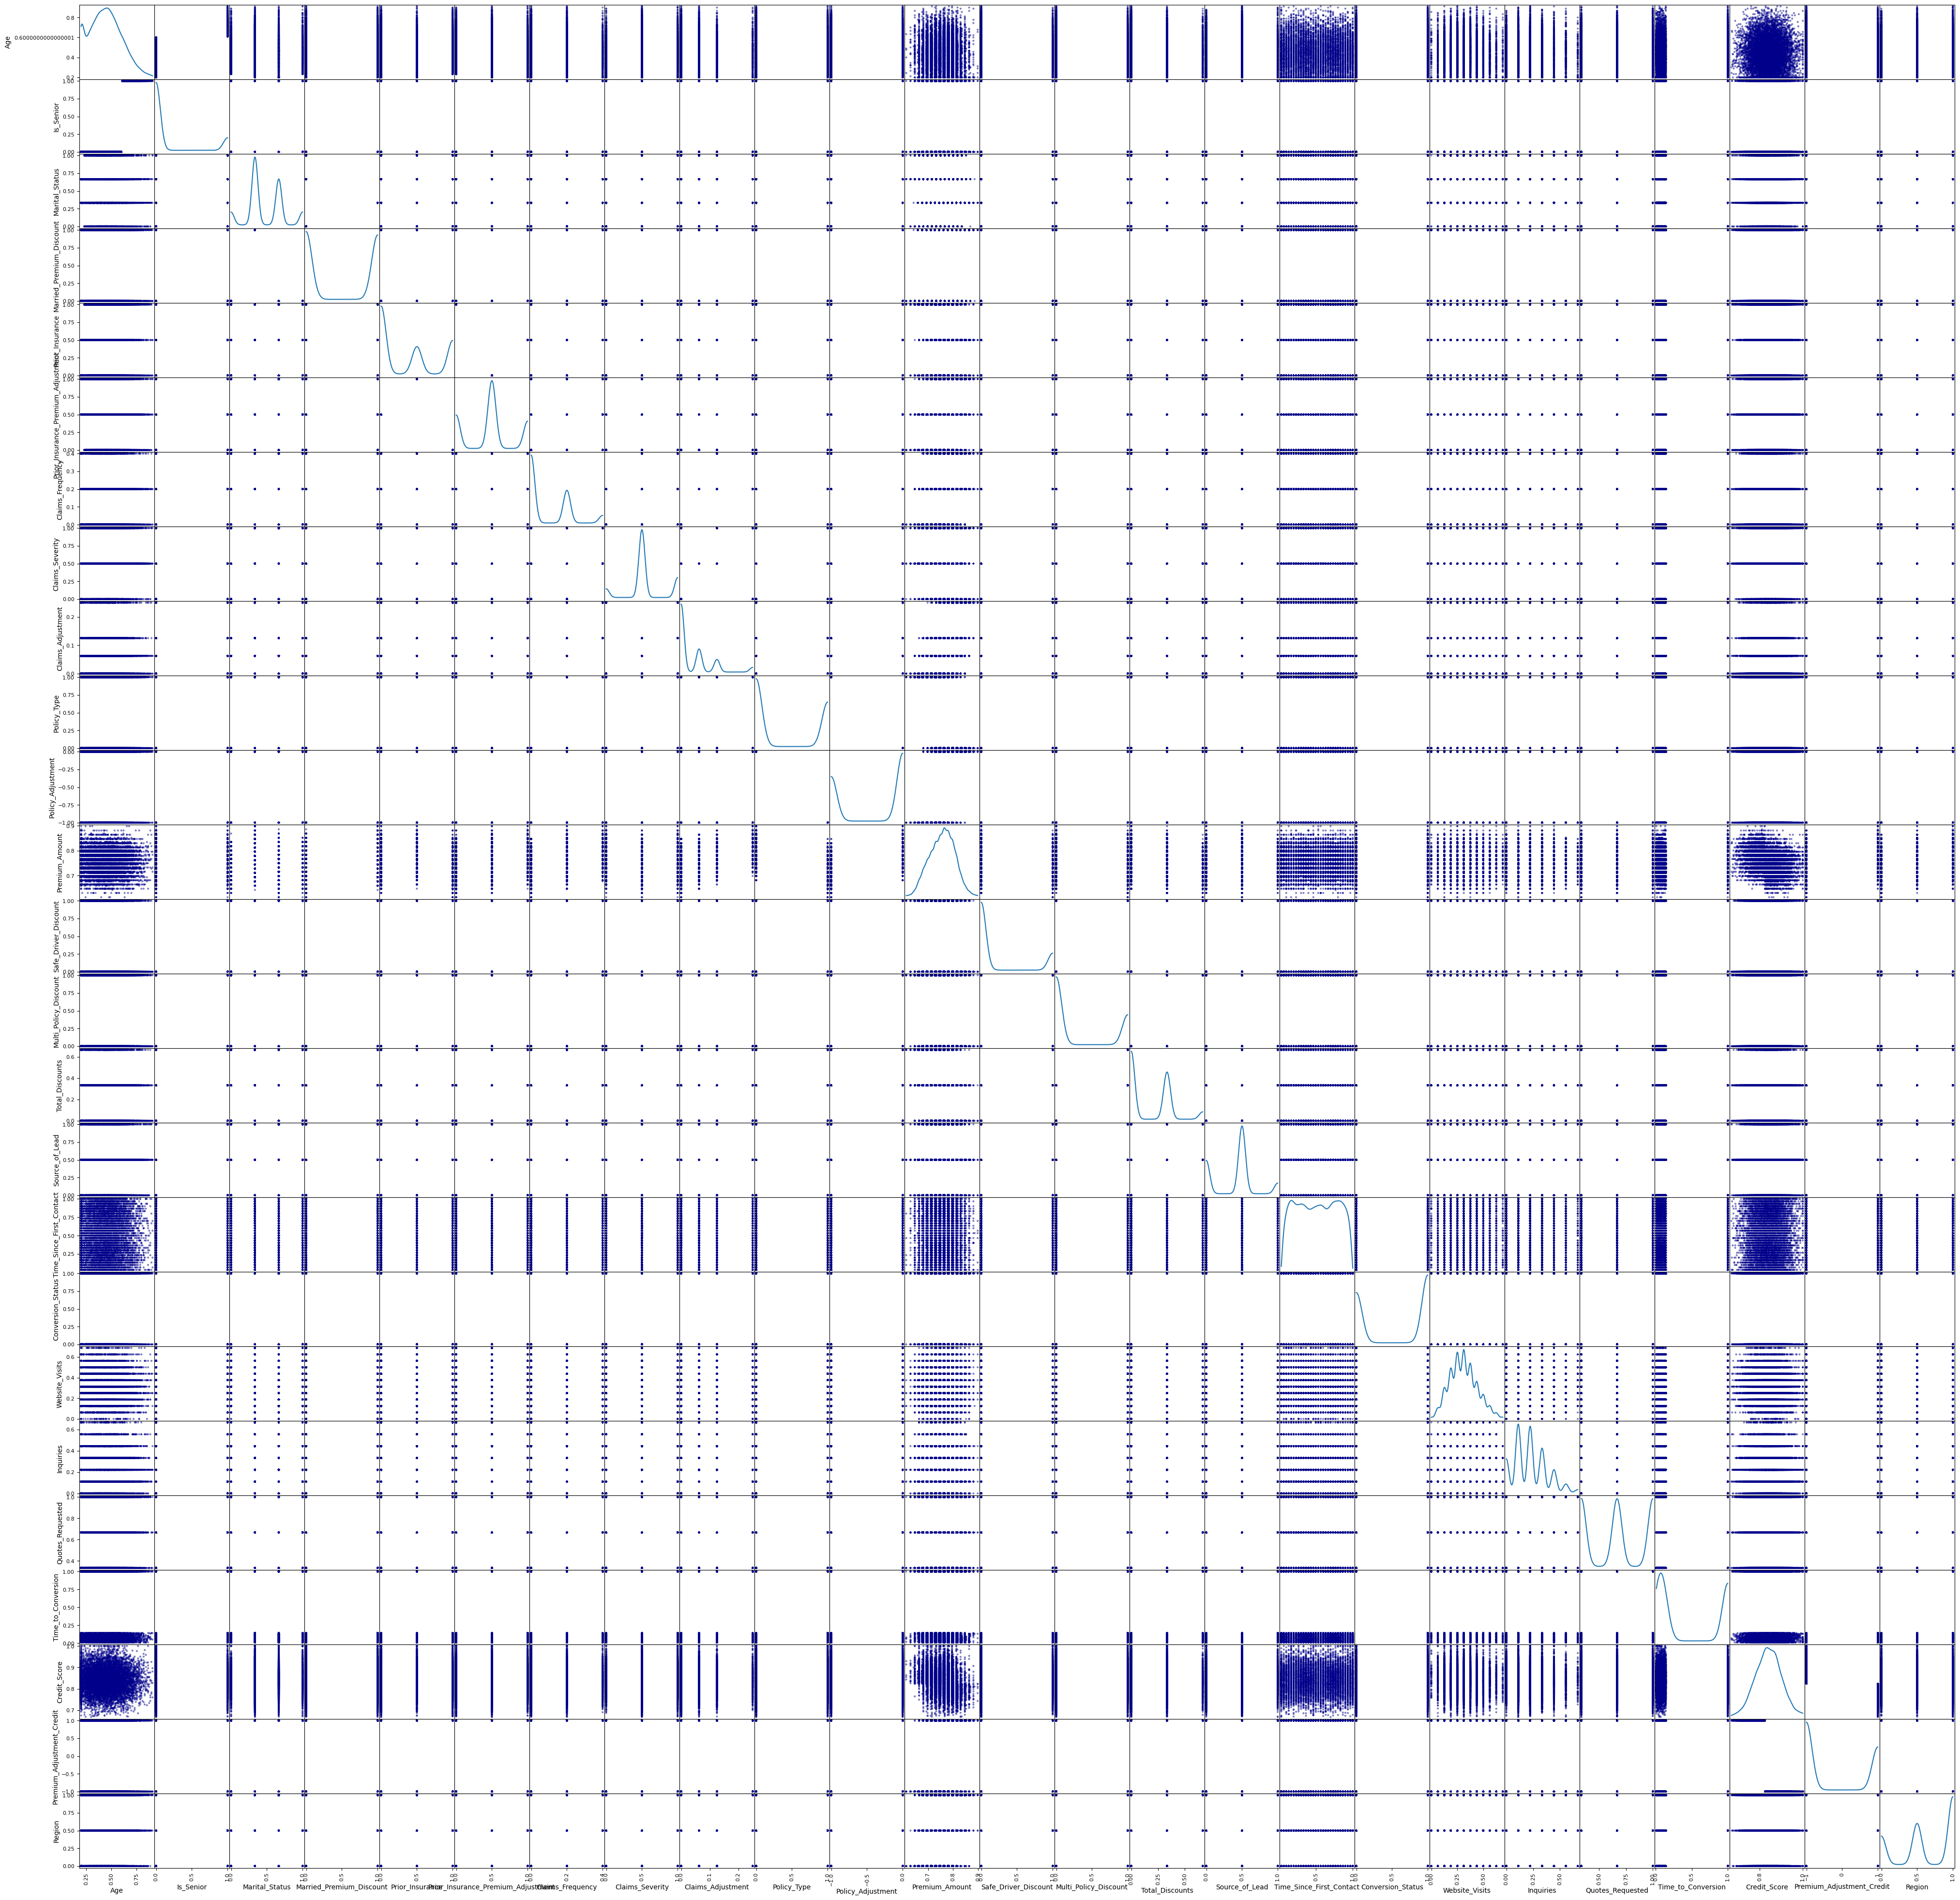

In [153]:
from pandas.plotting import scatter_matrix

scatter_matrix(X, alpha = 0.5, figsize = (50, 50), diagonal = "kde", c="#00008B");

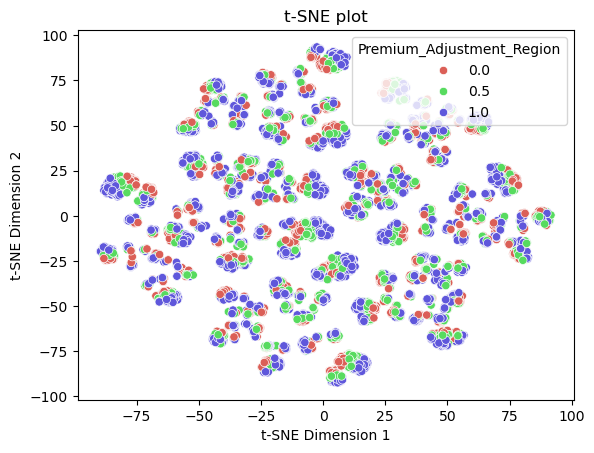

In [186]:
from sklearn.manifold import TSNE
import seaborn as sn

tsne = TSNE(n_components = 2, random_state = 42)
X_embedded = tsne.fit_transform(X)

sn.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette=sn.color_palette("hls", 3))
plt.title("t-SNE plot")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

## Training Model ##

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [191]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [193]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6075, 25)
(1302, 25)
(1302, 25)


In [195]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.array(X), dtype = torch.float32).to(device)
        self.y = torch.tensor(np.array(y), dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [197]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [251]:
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 32, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = 32, shuffle = True)

In [357]:
Hidden_Neurons = 333

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(X.shape[1], Hidden_Neurons)
        
        self.hidden_layer1 = nn.Linear(X.shape[1], Hidden_Neurons)
        self.hidden_layer2 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer3 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer4 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer5 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer6 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer7 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer8 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer9 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer10 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer11 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer12 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        self.hidden_layer13 = nn.Linear(Hidden_Neurons, Hidden_Neurons)
        
        self.linear = nn.Linear(Hidden_Neurons, 1) #output layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        #Forward Propagation
        x = x.to(device)
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)

In [359]:
summary(model, (X.shape[1],), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1]                       1,343,322
├─Linear: 1-1                            [333]                     8,658
├─Linear: 1-2                            [1]                       334
├─Sigmoid: 1-3                           [1]                       --
Total params: 1,352,314
Trainable params: 1,352,314
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

In [369]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 1e-3)

In [371]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction, labels)
        
        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        #Back Propagation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = criterion(prediction, labels)
        
            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/training_data.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/validation_data.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1 
    Training Loss: 0.071 
    Training Accuracy: 66.8148 
    Validation Loss: 0.0097 
    Validation Accuracy: 69.9693
Epoch no. 2 
    Training Loss: 0.0421 
    Training Accuracy: 69.9753 
    Validation Loss: 0.0088 
    Validation Accuracy: 69.9693
Epoch no. 3 
    Training Loss: 0.0403 
    Training Accuracy: 69.9753 
    Validation Loss: 0.0086 
    Validation Accuracy: 69.9693
Epoch no. 4 
    Training Loss: 0.0399 
    Training Accuracy: 69.9753 
    Validation Loss: 0.0086 
    Validation Accuracy: 69.9693
Epoch no. 5 
    Training Loss: 0.0398 
    Training Accuracy: 69.9753 
    Validation Loss: 0.0086 
    Validation Accuracy: 69.9693
Epoch no. 6 
    Training Loss: 0.0398 
    Training Accuracy: 69.9753 
    Validation Loss: 0.0086 
    Validation Accuracy: 69.9693
Epoch no. 7 
    Training Loss: 0.0397 
    Training Accuracy: 69.9753 
    Validation Loss: 0.0086 
    Validation Accuracy: 69.9693
Epoch no. 8 
    Training Loss: 0.0397 
    Training Accuracy: 

In [373]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in testing_dataloader:
        inputs, labels = data
        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test
        
        acc = (prediction.round() == labels).sum().item()
        
        total_acc_test += acc
        total_loss_test += batch_loss_test

print(f'''Accuracy Score: {round(total_acc_test/testing_data.__len__()*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 56.682 
Loss: 0.0104


## Post-Training Analysis ##

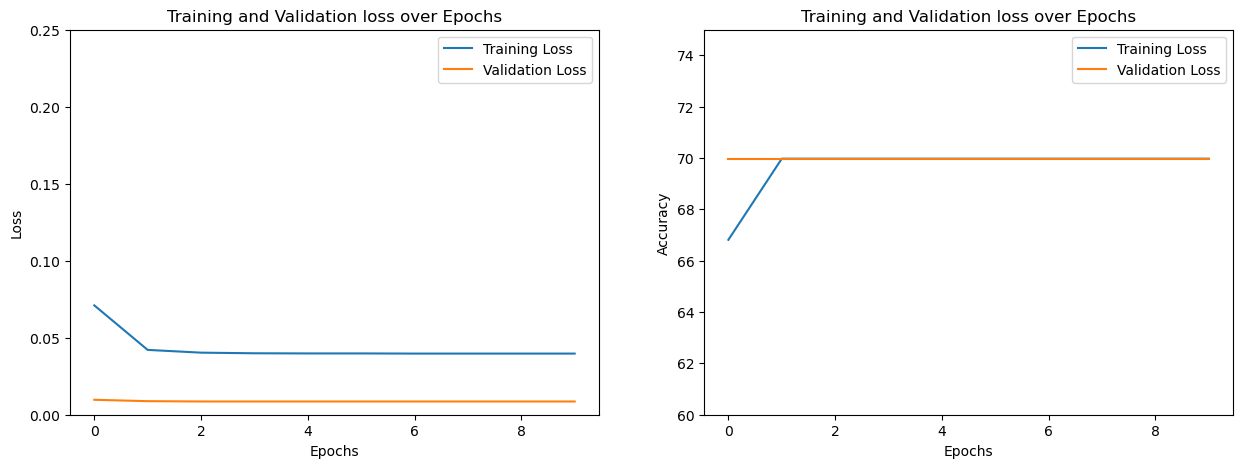

In [385]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.25])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([60,75])
axs[1].legend()

plt.show()

In [387]:
torch.save(model.state_dict(), "Insurance.pth")

In [389]:
loaded_model = MyModel().to(device)
loaded_model.load_state_dict(torch.load("Insurance.pth"))
loaded_model.eval()

MyModel(
  (input_layer): Linear(in_features=25, out_features=333, bias=True)
  (hidden_layer1): Linear(in_features=25, out_features=333, bias=True)
  (hidden_layer2): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer3): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer4): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer5): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer6): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer7): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer8): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer9): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer10): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer11): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer12): Linear(in_features=333, out_features=333, bias=True)
  (hidden_layer13): Linear(in_features=333, out_features